In [10]:
import numpy as np
import math,pickle
import pandas as pd

In [11]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

from lib.mobilitysim_split import MobilitySimulator
from lib.distributions import CovidDistributions


# converting days to hours
TO_HOURS = 24.0

from lib.slim_dynamics import *

In [12]:
# Choose random seed
c = 0
# Set it
np.random.seed(c)
# Define prefix string used to save plots
runstr = f'run{c}_'

In [13]:
max_time= 720 #in hours

In [14]:
from lib.settings.town_settings_tubingen import *
mob_settings = '../lib/mobility/Tubingen_settings_pop10_site10.pk'  
area = 'TU'
country = 'GER'

# See town-generator.ipynb for an example on how to create the settings
with open(mob_settings, 'rb') as fp:
    obj = pickle.load(fp)
    
n_indiv=int(obj['num_people_unscaled']/obj['downsample_pop'])

All necessary distributions with parameteres from recent literature are imported

In [15]:
distributions = CovidDistributions(country=country)

In [16]:
beta = 0.8 # this parameter enters in the conditional intensity during contacts 

#possibly different values of beta can be defined or inferred (see calibrate.py)
intensity_params = {
    'betas' : {
        'education': beta,
        'social': beta,
        'bus_stop': beta,
        'office': beta,
        'supermarket': beta}, 
    'beta_household' : beta
}

In [17]:
initial_counts = {'expo': 5, 'isym': 3, 'iasy': 3} #in the form {'expo': 7, 'isym_posi': 2, 'iasy': 2}
initial_seeds=get_seeds(n_indiv, initial_counts)
initial_seeds

{'expo': [1220, 2092, 6550, 489, 1570],
 'isym': [2655, 4422, 2658],
 'iasy': [2652, 4771, 6814]}

In [18]:
results = run(mob_settings, intensity_params, distributions, max_time, initial_seeds)

t: 720.00 | 720.00 hrs (30 d)
[Reached max time: 720h (30d)]


In [19]:
def is_state_at(sim, state, t):
    
    return (sim.state_started_at[state] <= t) & (sim.state_ended_at[state] > t)



def comp_state_over_time(sim, states):
    '''
    Computes `state` variable over time [0, self.max_time] with given accuracy `acc
    '''
    ts, val = [], []
    for t in np.linspace(0.0, sim.max_time, num=sim.max_time, endpoint=True):
        ts.append(t/24)
        val.append(sum([np.sum(is_state_at(sim, s, t)) for s in states]))
    return np.array(ts), np.array(val)


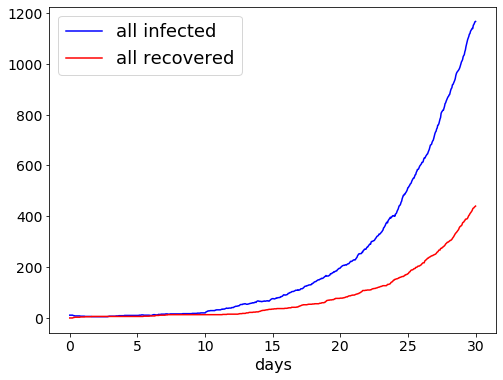

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,6))
states=['expo','ipre','iasy','isym','hosp']
ts, val = comp_state_over_time(results, states)
plt.plot(ts, val, c='b', linestyle='-',label='all infected')
states=['resi','dead']
ts, val = comp_state_over_time(results, states)
plt.plot(ts, val, c='r', linestyle='-',label='all recovered')
plt.xlabel('days',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)
plt.show()

In [21]:
status= {'susc': 0, 'expo': 1, 'ipre': 1, 'isym': 1, 'iasy': 1, 'resi': 2, 'dead': 2, 'hosp': 1}
max_day=max_time//24
conf={}
for t in range(max_day):
    conf[t]=0*results.snapshots[t]['susc'][:] + 1*(results.snapshots[t]['expo'][:]+results.snapshots[t]['ipre'][:] \
                                                   +results.snapshots[t]['isym'][:]+results.snapshots[t]['iasy'][:] \
                                                   +results.snapshots[t]['hosp'][:]) \
            + 2*(results.snapshots[t]['resi'][:]+results.snapshots[t]['dead'][:])

conf_df=pd.DataFrame(conf)
conf_df.to_csv('confs_Tubingen.csv')    

In [22]:
cont=[]
for i in results.mob.contacts:
    for j in results.mob.contacts[i]:
        for h in results.mob.contacts[i][j]:
            cont.append((h.indiv_i,h.indiv_j,h.t_from, h.t_to, h.t_to-h.t_from))

In [23]:
contact_raw= pd.DataFrame(data=cont, columns=['indiv_i', 'indiv_j', 't_from', 't_to', 'deltat'])

In [24]:
contact_raw.to_csv('contacts_Tubingen.csv', index=True) 

In [25]:
contact_raw

,indiv_i,indiv_j,t_from,t_to,deltat
0,0,597,171.935842,172.105573,0.169731
1,0,2430,171.935842,172.142783,0.206941
2,0,3083,171.939103,172.142783,0.203680
3,0,3495,171.935842,172.142783,0.206941
4,0,3974,171.935842,172.029252,0.093410
...,...,...,...,...,...
3510145,9053,5140,149.224441,149.402139,0.177699
3510146,9053,5190,149.212259,149.266793,0.054534
3510147,9053,5278,149.212259,149.402139,0.189880
3510148,9053,6811,149.212259,149.402139,0.189880


In [26]:
#keep resolution of 15min
contact_raw2=contact_raw[contact_raw['deltat']>0.25]
contact_raw2=contact_raw2.reset_index()
contact_raw2.drop(columns=['index'],inplace=True)
contact_raw2

,indiv_i,indiv_j,t_from,t_to,deltat
0,0,17,294.320705,295.562099,1.241394
1,0,209,74.228038,75.344297,1.116259
2,0,387,132.438909,134.285618,1.846709
3,0,388,73.498460,75.344297,1.845838
4,0,465,294.422407,295.562099,1.139691
...,...,...,...,...,...
2318077,9053,6916,327.855158,328.580144,0.724987
2318078,9053,7047,326.623392,327.587698,0.964306
2318079,9053,7384,327.435902,330.093194,2.657292
2318080,9053,7416,326.434779,327.217648,0.782869


In [27]:
t_unit = 24
period = np.arange(0,max_time+t_unit,t_unit*1.0)
print(period)

[  0.  24.  48.  72.  96. 120. 144. 168. 192. 216. 240. 264. 288. 312.
 336. 360. 384. 408. 432. 456. 480. 504. 528. 552. 576. 600. 624. 648.
 672. 696. 720.]


In [28]:
n_contacts=len(contact_raw2)
indiv_i=contact_raw2.indiv_i.to_numpy()
indiv_j=contact_raw2.indiv_j.to_numpy()
t_from=contact_raw2.t_from.to_numpy()
t_to=contact_raw2.t_to.to_numpy()
dt=contact_raw2.deltat.to_numpy()    

In [29]:
cont_sqzd_dict={}
for i in range(n_contacts):
    mlen=int(dt[i]//t_unit)
    for s in range(mlen+1):
        a=(indiv_i[i],indiv_j[i],int(t_from[i])//t_unit +s)
        if a in cont_sqzd_dict:
            cont_sqzd_dict[a]+=(1 if s<mlen else (dt[i]/t_unit - mlen))
            
        else:
            cont_sqzd_dict[a]=(1 if s<mlen else (dt[i]/t_unit - mlen))

In [30]:
cont_sqzd=[]
l=list(cont_sqzd_dict.keys())
for a in l:
    cont_sqzd+=[(a[0],a[1],a[2], 1.0-np.exp(-beta*cont_sqzd_dict[a]))]
    cont_sqzd+=[(a[1],a[0],a[2], 1.0-np.exp(-beta*cont_sqzd_dict[a]))]

In [31]:
#cont_sqzdClean=set(cont_sqzd)
cont2_sqzd = pd.DataFrame(cont_sqzd,columns=['i', 'j', 't', 'lambda'])

In [32]:
cont_sqzd_sorted=cont2_sqzd.sort_values(by=['t','i'],ascending=True)

In [33]:
cont_sqzd_sorted.to_csv('cont_miniTubingen.csv', index=False) 

In [34]:
cont_sqzd_sorted

,i,j,t,lambda
1954,4,753,0,0.036246
1960,4,778,0,0.045318
1962,4,1046,0,0.070546
1966,4,1186,0,0.038721
1976,4,1373,0,0.040586
...,...,...,...,...
3998775,9051,7946,29,0.037533
4550686,9051,3170,29,0.014778
4550748,9051,5307,29,0.024902
4550810,9051,7828,29,0.010573


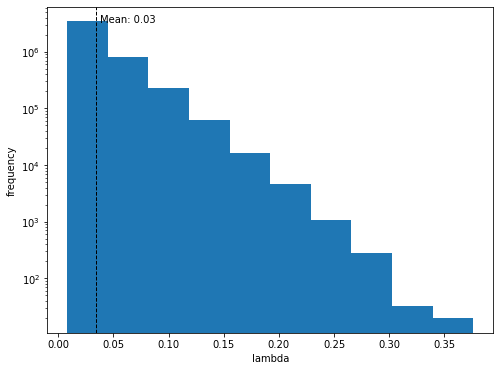

In [50]:
lamb=np.array([cont_sqzd[i][3] for i in range(len(cont_sqzd))])
plt.figure(figsize=(8,6))
plt.hist(lamb)
plt.axvline(lamb.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(lamb.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(lamb.mean()))
plt.yscale('log')
plt.xlabel('lambda')
plt.ylabel('frequency')
plt.show()

0.036524910025633406